### How to use PyTorch LSTMs for time series regression

##### 1. 라이브러리 불러오기

In [1]:
import os
import pandas as pd             #데이터를 Dataframe으로 다루는 라이브러리
from pandas import DataFrame
import numpy as np              #데이터를 행열 또는 array 형태로 다루는 라이브러리
import matplotlib.pyplot as plt #데이터를 그래프 plot으로 보여주는 라이브러리
import seaborn as sns

import requests                 #네트워크 접근 라이브러리
from bs4 import BeautifulSoup   #웹사이트 접근하는 라이브러리

from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
torch.manual_seed(77)

from torch import nn as nn
from torch.nn import functional as F

import warnings
warnings.filterwarnings('ignore')

##### 2. KRX 종목으로 주가종목 데이터 가져오기

In [3]:
target = '삼성전자'

# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와
# 네이버 금융(http://finance.naver.com)에 넣어줌

code_krx = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', encoding='cp949', header=0)[0]
# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌
code_krx.종목코드 = code_krx.종목코드.map('{:06d}'.format)
# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다.
code_krx = code_krx[['회사명', '종목코드']]
# code_krx
target_code = code_krx[code_krx['회사명']==target]
target_code

,회사명,종목코드
1807,삼성전자,005930


In [4]:
# 종목코드로 네이버에서 종목 주소 생성 확인
def get_url(code): #(item_name, code_df):
    url = 'https://finance.naver.com/item/sise_day.naver?code='+'{code}'.format(code=code).lstrip()
    return url
code = target_code['종목코드'].iloc[0]
url = get_url(code)
url

'https://finance.naver.com/item/sise_day.naver?code=005930'

In [5]:
# 위에서 찾은 네이버 타겟종목 페이지에서 마지막 페이지 크기 확인
url_page = url + '&page=1'
headers = {'User-agent':'Mozilla/5.0'}
html = requests.get(url_page, headers=headers).text
soup = BeautifulSoup(html,"html.parser")
tags = soup.find_all('a')
# print(tags[11]["href"])
last_page = tags[11]["href"]
last_page = last_page.split('=')[2]
last_page
# print(f"target_code :회사명 == [{target_code['회사명'].iloc[0]}] 종목코드 == [{target_code['종목코드'].iloc[0]}] 마지막 페이지 == [{last_page}]")

'725'

In [6]:
last_page = 50 # 임시 50 페이지 까지만

# 일 데이터를 담을 df_code라는 DataFrame 정의
df_code = pd.DataFrame()
url.lstrip()
for page in range(1,int(last_page)+1):
    # pg_url = ('{url}&page={page}'.format(url=url, page=page)).lstrip()
    # pg = pd.read_html(pg_url,encoding='euc-kr',header=1)[0]
    # df_code = pd.concat([df_code,pg])
    req = requests.get(f'{url}&page={page}',headers=headers)
    df_code = pd.concat([df_code,pd.read_html(req.text,encoding='euc-kr')[0]],ignore_index=True)

# df.dropna()를 이용해 결측값 있는 행 제거
df_code = df_code.dropna()
df_code.reset_index(drop=True, inplace=True)

# 상위 15개 데이터 확인하기
df_code.head(15)


,날짜,종가,전일비,시가,고가,저가,거래량
0,2025.06.02,56800.0,상승 600,56300.0,57300.0,56200.0,12612797.0
1,2025.05.30,56200.0,상승 100,56200.0,57200.0,55800.0,26219683.0
2,2025.05.29,56100.0,상승 200,56200.0,56400.0,55600.0,12936810.0
3,2025.05.28,55900.0,"상승 2,000",54300.0,56100.0,54200.0,17516283.0
4,2025.05.27,53900.0,하락 800,54200.0,54500.0,53800.0,13439520.0
5,2025.05.26,54700.0,상승 500,53900.0,55000.0,53700.0,10901337.0
6,2025.05.23,54200.0,하락 500,55000.0,55200.0,54100.0,11247115.0
7,2025.05.22,54700.0,"하락 1,000",55300.0,55500.0,54500.0,15254278.0
8,2025.05.21,55700.0,하락 200,56200.0,56600.0,55700.0,7794181.0
9,2025.05.20,55900.0,상승 100,56200.0,56700.0,55700.0,9080577.0


##### data split

In [ ]:
# 한글로 된 컬럼명을 영어로 바꿔줌
stock_data = df_code.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'})
stock_data['diff'] = stock_data['diff'].str.replace('상승','').str.replace('하락','').str.replace('보합','').str.replace(',','').str.replace(' ','').str.strip()
# 데이터의 타입을 int형으로 바꿔줌
stock_data[['close', 'diff', 'open', 'high', 'low', 'volume']] = stock_data[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(float)
# 컬럼명 'date'의 타입을 date로 바꿔줌
stock_data['date'] = pd.to_datetime(stock_data['date'])
# 일자(date)를 기준으로  정렬
stock_data = stock_data.sort_values(by=['date'],ascending = True)
# 상위 5개 데이터 확인
print(stock_data.shape)
stock_data.reset_index(drop=True, inplace=True)
stock_data.head(15)

(500, 7)


,date,close,diff,open,high,low,volume
0,2023-05-12,64100.0,100.0,63700.0,64600.0,63600.0,8693913.0
1,2023-05-15,64500.0,400.0,64100.0,64600.0,63900.0,8172021.0
2,2023-05-16,65400.0,900.0,65800.0,65900.0,65300.0,12334657.0
3,2023-05-17,65000.0,400.0,65900.0,65900.0,64800.0,10745504.0
4,2023-05-18,66200.0,1200.0,66000.0,66200.0,65700.0,14431704.0
5,2023-05-19,68400.0,2200.0,67800.0,68400.0,67500.0,20349345.0
6,2023-05-22,68500.0,100.0,68400.0,69000.0,68000.0,14470308.0
7,2023-05-23,68400.0,100.0,68500.0,68700.0,68100.0,8561643.0
8,2023-05-24,68500.0,100.0,68100.0,68700.0,68000.0,8192896.0
9,2023-05-25,68800.0,300.0,69900.0,70000.0,68700.0,14231160.0


In [76]:
df = stock_data.copy()
df = df.set_index('date')
df

,close,diff,open,high,low,volume
date,,,,,,
2023-05-12,64100.0,100.0,63700.0,64600.0,63600.0,8693913.0
2023-05-15,64500.0,400.0,64100.0,64600.0,63900.0,8172021.0
2023-05-16,65400.0,900.0,65800.0,65900.0,65300.0,12334657.0
2023-05-17,65000.0,400.0,65900.0,65900.0,64800.0,10745504.0
2023-05-18,66200.0,1200.0,66000.0,66200.0,65700.0,14431704.0
...,...,...,...,...,...,...
2025-05-27,53900.0,800.0,54200.0,54500.0,53800.0,13439520.0
2025-05-28,55900.0,2000.0,54300.0,56100.0,54200.0,17516283.0
2025-05-29,56100.0,200.0,56200.0,56400.0,55600.0,12936810.0


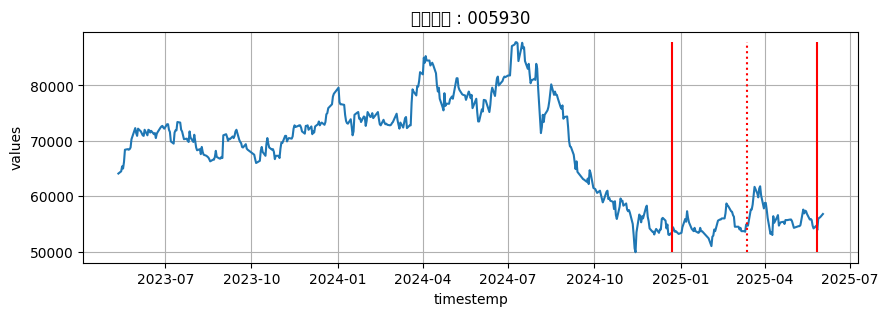

In [77]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(df['close'])
ax.vlines(df[df.index == df.iloc[round(len(df)*0.79)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= '-')
ax.vlines(df[df.index == df.iloc[round(len(df)*0.89)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= ':')
ax.vlines(df[df.index == df.iloc[round(len(df)*0.99)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= '-')
ax.set_title(target + ' : ' + code)
ax.set_xlabel('timestemp')
ax.set_ylabel('values')
ax.grid()
fig.tight_layout
plt.show()

In [78]:
# 데이터를 훈련, 검증, 테스트로 나눈다.
df_train = df.iloc[:round(len(df)*0.8)]
df_valid = df.iloc[round(len(df)*0.8):round(len(df)*0.9)]
df_test = df.iloc[round(len(df)*0.9):len(df)]

print(f" df.shape 0.8 : {round(df.shape[0]*0.8)}")
print(f" df_train.shape : {df_train.shape}")
print(f" df_valid.shape : {df_valid.shape}")
print(f" df_test.shape : {df_test.shape}")
print(f" check {(round(df.shape[0]*0.7)) == df_train.shape[0]+df_valid.shape[0]+df_test.shape[0]}")

 df.shape 0.8 : 400
 df_train.shape : (400, 6)
 df_valid.shape : (50, 6)
 df_test.shape : (50, 6)
 check False


In [79]:
df_train

,close,diff,open,high,low,volume
date,,,,,,
2023-05-12,64100.0,100.0,63700.0,64600.0,63600.0,8693913.0
2023-05-15,64500.0,400.0,64100.0,64600.0,63900.0,8172021.0
2023-05-16,65400.0,900.0,65800.0,65900.0,65300.0,12334657.0
2023-05-17,65000.0,400.0,65900.0,65900.0,64800.0,10745504.0
2023-05-18,66200.0,1200.0,66000.0,66200.0,65700.0,14431704.0
...,...,...,...,...,...,...
2024-12-23,53500.0,500.0,53400.0,54000.0,53300.0,13672650.0
2024-12-24,54400.0,900.0,53700.0,54500.0,53600.0,11634677.0
2024-12-26,53600.0,800.0,54500.0,54600.0,53500.0,10517075.0


In [93]:
scaler = StandardScaler()
scaler.fit(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df.columns)
df_valid_scaled = pd.DataFrame(scaler.transform(df_valid),columns=df.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df.columns)

In [83]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5, predict_length=1):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.predict_length = predict_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        self.datetime = dataframe.index 

    def __len__(self):
        return len(self.X) - (self.sequence_length + self.predict_length)
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.sequence_length
        seq_x = self.X[s_begin:s_end]
        r_begin = s_end - self.predict_length
        r_end = r_begin + self.predict_length
        seq_y = self.y[r_begin :r_end]
        return seq_x, seq_y

 # start point padding type
    # def __len__(self):
    #     return self.X.shape[0]

    # def __getitem__(self, i): 
    #     if i >= self.sequence_length - 1:
    #         i_start = i - self.sequence_length + 1
    #         x = self.X[i_start:(i + 1), :]
    #     else:
    #         padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
    #         x = self.X[0:(i + 1), :]
    #         x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [89]:
target='close'
features= df.columns
sequence_length = 10
predict_length = 1

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

i = 27
X, y = train_dataset[i]
print(X)
print(y)

tensor([[ 0.0235, -0.1159, -0.1237, -0.0426, -0.0500, -0.8162],
        [ 0.0608, -0.6983,  0.0990,  0.0445,  0.1379, -0.7114],
        [ 0.1602, -0.1159,  0.0619,  0.0818,  0.1254, -0.9153],
        [ 0.1851, -0.8148,  0.1609,  0.0943,  0.1880, -1.0407],
        [ 0.1975, -0.9313,  0.1732,  0.1067,  0.1880, -1.1160],
        [ 0.1602, -0.6983,  0.2351,  0.1938,  0.2381, -0.7227],
        [ 0.1354, -0.8148,  0.1609,  0.1067,  0.1504, -0.7838],
        [ 0.2348, -0.1159,  0.1856,  0.1689,  0.2631, -0.8948],
        [ 0.2348, -1.0478,  0.2722,  0.2186,  0.3007, -0.9527],
        [ 0.1105,  0.1171,  0.2227,  0.1813,  0.1754, -0.7135]])
tensor([0.1105])


In [90]:
X, y = train_dataset[i+1]
print(X)
print(y)

tensor([[ 0.0608, -0.6983,  0.0990,  0.0445,  0.1379, -0.7114],
        [ 0.1602, -0.1159,  0.0619,  0.0818,  0.1254, -0.9153],
        [ 0.1851, -0.8148,  0.1609,  0.0943,  0.1880, -1.0407],
        [ 0.1975, -0.9313,  0.1732,  0.1067,  0.1880, -1.1160],
        [ 0.1602, -0.6983,  0.2351,  0.1938,  0.2381, -0.7227],
        [ 0.1354, -0.8148,  0.1609,  0.1067,  0.1504, -0.7838],
        [ 0.2348, -0.1159,  0.1856,  0.1689,  0.2631, -0.8948],
        [ 0.2348, -1.0478,  0.2722,  0.2186,  0.3007, -0.9527],
        [ 0.1105,  0.1171,  0.2227,  0.1813,  0.1754, -0.7135],
        [ 0.0608, -0.5819,  0.0866,  0.0694,  0.1254, -0.4321]])
tensor([0.0608])


In [91]:
print(df_train[features].iloc[i: (i + sequence_length)])

              close    diff     open     high      low      volume
date                                                              
2023-06-22  71300.0   800.0  70200.0  71500.0  70100.0  11411007.0
2023-06-23  71600.0   300.0  72000.0  72200.0  71600.0  12329484.0
2023-06-26  72400.0   800.0  71700.0  72500.0  71500.0  10541901.0
2023-06-27  72600.0   200.0  72500.0  72600.0  72000.0   9442997.0
2023-06-28  72700.0   100.0  72600.0  72700.0  72000.0   8783093.0
2023-06-29  72400.0   300.0  73100.0  73400.0  72400.0  12229967.0
2023-06-30  72200.0   200.0  72500.0  72700.0  71700.0  11694765.0
2023-07-03  73000.0   800.0  72700.0  73200.0  72600.0  10722181.0
2023-07-04  73000.0     0.0  73400.0  73600.0  72900.0  10214350.0
2023-07-05  72000.0  1000.0  73000.0  73300.0  71900.0  12310610.0


In [92]:
def my_collate_fn(batch):
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    # batch_first=True로 설정
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=0) # padding_value는 선택 
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return padded_batch #, labels_tensor

In [95]:
target = 'close'
features = df_train_scaled.columns
batch_size = 30
sequence_length = 12
predict_length = 1

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
valid_dataset = SequenceDataset(
    df_valid_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
test_dataset = SequenceDataset(
    df_test_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)#, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)#, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)#,collate_fn=my_collate_fn)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([30, 12, 6])
Target shape: torch.Size([30, 1])


In [159]:
# df_train.describe()
mean = df_train.mean()
var = df_train.var()

In [16]:
# valid_loader = DataLoader(valid_dataset, batch_size=30, shuffle=False)

# X,y = next(iter(valid_loader))
# print(X.shape)
# print(X)
# print(y)

# X, y = valid_dataset[391]
# print(X)
# print(y)

### LSTM Model

In [237]:
class LSTM_Layer(nn.Module):
    def __init__(self, 
                 num_features, 
                 hidden_units,
                 predict_length, 
                 bias=True, 
                 num_layers=3, 
                 drop_ratio=0.0,
                 bi_dir=False,
                 device='cpu'):
        super().__init__()
        self.num_features = num_features  # feature's = 현재 1
        self.hidden_units = hidden_units
        self.bias = bias
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.bi_dir = bi_dir
        self.device = device

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            bias=bias,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=drop_ratio,
            bidirectional=bi_dir
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=predict_length, bias=bias)

        self.sig = nn.Sigmoid()
        self.Tanh = nn.Tanh()

    def forward(self, x):
        # print(f"x.shape-ori: {x.shape}")
        # x = x.unsqueeze(2)
        # print(f"x.shape-unsqz : {x.shape}")
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        hh, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn)

        return out

In [178]:
len(features)

6

In [238]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"is_available device : {device}")

learning_rate = 0.003
num_hidden_units = 124
epochs = 50

model = LSTM_Layer(num_features=len(features), hidden_units=num_hidden_units, predict_length=predict_length, device=device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


is_available device : cuda


In [315]:
def train_model(data_loader, model, loss_function, optimizer, device):
    num_batches = len(data_loader)
    total_loss = 0
    model.to(device)
    
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def eval_model(data_loader, model, loss_function, device=device):
    num_batches = len(data_loader)
    total_loss = 0
    
    model.to(device)

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            # print(f"input x : {X.shape}")
            # print(f"label y : {y.shape}")
            # print(f"output : {output.shape}")
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"eval loss: {avg_loss}")
    return avg_loss


def infer_model(data_loader, model, device=device):
    num_batches = len(data_loader)
    total_loss = 0
    predict = []
    label = []
    model.to(device)

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            # print(output.shape)
            # raise
            pred = output.to('cpu').numpy()
            np.squeeze(pred)
            predict.append(list(pred[0]))
            true = y.to('cpu').numpy()
            np.squeeze(true)
            label.append(list(true[0]))
        
    return predict, label


def forecasting (data, model, device=device):
    model.to(device)
    model.eval()
    with torch.no_grad():
            X = torch.from_numpy(data).to(torch.float32).to(device)
            X = X.unsqueeze(0)
            output = model(X)
            forecast = output.to('cpu').numpy()
            forecast = np.squeeze(forecast[0])
        
    return forecast


In [240]:
print("Untrained evaluate\n--------")
eval_model(test_loader, model, loss_function, device=device)
print()

epoch = []
train_loss_list = []
eval_loss_list = []

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer, device=device)
    eval_loss = eval_model(valid_loader, model, loss_function, device=device)
    print()
    epoch.append(ix_epoch+1)
    train_loss_list.append(train_loss)
    eval_loss_list.append(eval_loss)
result = pd.DataFrame({'epoch':epoch, 'train_loss':train_loss_list, 'eval':eval_loss_list})
result


Untrained evaluate
--------
eval loss: 3.9502698988527865

Epoch 0
---------
Train loss: 0.39273382785419625
eval loss: 0.47122514247894287

Epoch 1
---------
Train loss: 0.1182442248488466
eval loss: 0.09973210841417313

Epoch 2
---------
Train loss: 0.056836252411206566
eval loss: 0.04841633141040802

Epoch 3
---------
Train loss: 0.03485148229325811
eval loss: 0.05731578543782234

Epoch 4
---------
Train loss: 0.03034989597896735
eval loss: 0.038788340985774994

Epoch 5
---------
Train loss: 0.022676915551225345
eval loss: 0.03713709115982056

Epoch 6
---------
Train loss: 0.0191735114203766
eval loss: 0.030641822144389153

Epoch 7
---------
Train loss: 0.016790185201292235
eval loss: 0.025896407663822174

Epoch 8
---------
Train loss: 0.012922497815452516
eval loss: 0.028474999591708183

Epoch 9
---------
Train loss: 0.012093709704155723
eval loss: 0.021327760070562363

Epoch 10
---------
Train loss: 0.010388477084537348
eval loss: 0.01902756653726101

Epoch 11
---------
Train loss

,epoch,train_loss,eval
0,1,0.392734,0.471225
1,2,0.118244,0.099732
2,3,0.056836,0.048416
3,4,0.034851,0.057316
4,5,0.030350,0.038788
5,6,0.022677,0.037137
6,7,0.019174,0.030642
7,8,0.016790,0.025896
8,9,0.012922,0.028475
9,10,0.012094,0.021328


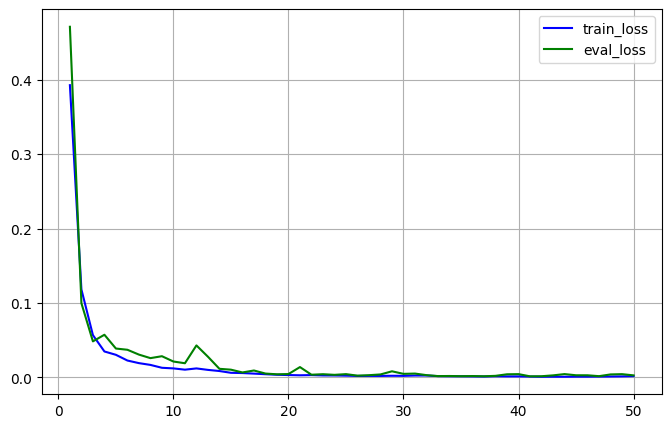

In [241]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(result['epoch'],result['train_loss'], color='blue', label='train_loss')
ax.plot(result['epoch'],result['eval'], color='green', label='eval_loss')
ax.legend()
ax.grid()
plt.show()

In [303]:
predict, trues = infer_model(test_loader, model=model, device=device)


In [304]:
predict = np.array(predict).squeeze()
trues = np.array(trues).squeeze()
infer_result = pd.DataFrame({'predict': predict, 'trues': trues}, index=test_dataset.datetime[13:])



In [305]:
infer_result.index = df_test.index[13:]
infer_result

,predict,trues
date,,
2025-04-08,-1.833962,-1.865036
2025-04-09,-2.203352,-2.225358
2025-04-10,-2.118632,-2.188083
2025-04-11,-2.155164,-2.250207
2025-04-14,-1.747688,-1.827762
2025-04-15,-1.925462,-1.976860
2025-04-16,-1.858828,-1.852611
2025-04-17,-1.760953,-1.802912
2025-04-18,-1.979999,-2.038985


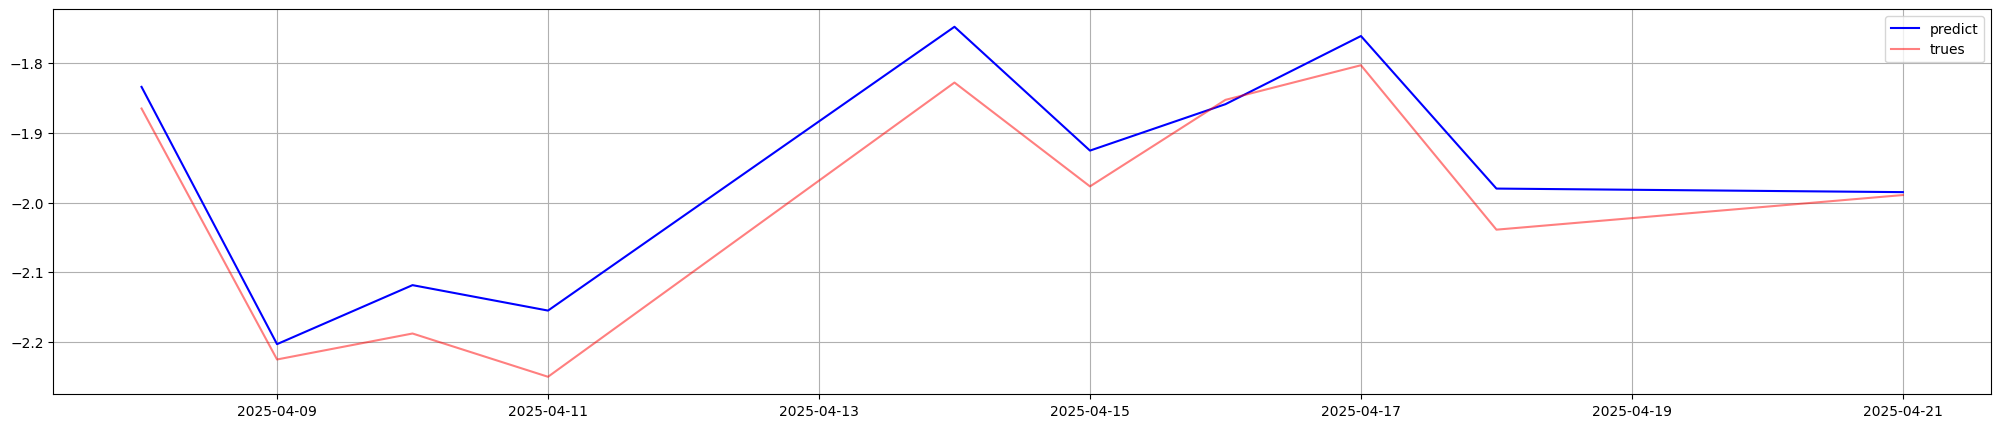

In [306]:
fig, ax = plt.subplots(1,1,figsize=(25,5))
ax.plot(infer_result['predict'].iloc[:10], color='blue', label='predict')
ax.plot(infer_result['trues'].iloc[:10], color='red', ls='-', alpha = 0.5, label='trues')
ax.legend()
ax.grid()
plt.show()

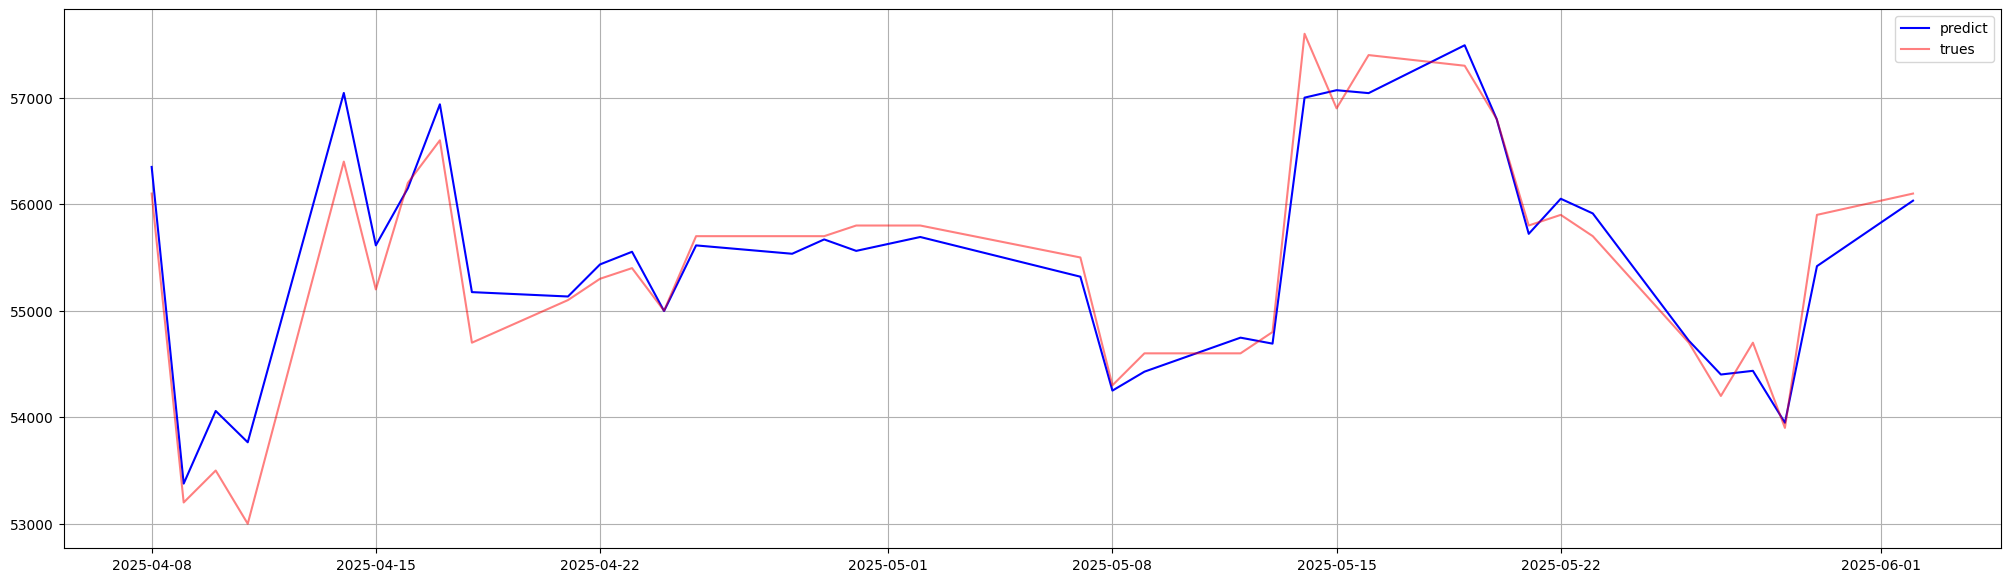

In [307]:
mean = scaler.mean_
var = scaler.var_

df_test_pred_descaled = (infer_result['predict'] * np.sqrt(var[0])) + mean[0]
df_test_gt_descaled = (infer_result['trues'] * np.sqrt(var[0])) + mean[0]

fig, ax = plt.subplots(1,1,figsize=(25,7))
ax.plot(df_test_pred_descaled, color='blue', label='predict')
ax.plot(df_test_gt_descaled, color='red', ls='-', alpha = 0.5, label='trues')
ax.legend()
ax.grid()
plt.show()

In [312]:
pred_input = df.iloc[488:500,:]
pred_input = scaler.transform(pred_input)
pred_input.shape

(12, 6)

In [316]:
forecast = forecasting(pred_input, model=model, device=device)

In [319]:
forecast * np.sqrt(scaler.var_[0]) + scaler.mean_[0]

56497.80749403924